In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Bernoulli
import torch.nn.functional as F
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import random
import os
import copy
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
global_epochs=300

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(42)

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, max_len=5000):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        return self.transformer_encoder(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model).cuda()
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CEVT(nn.Module):
    def __init__(self, dim_x, seq_len, dim_z=10, d_model=16, nhead=4, num_layers=2):
        super().__init__()
        self.dim_z = dim_z
        self.seq_len = seq_len
        
        # Encoder networks
        self.encoder = TransformerEncoder(dim_x, d_model, nhead, num_layers)
        self.q_t_indirect = nn.Linear(d_model * seq_len, 1)
        self.q_t = nn.Linear(d_model * seq_len + 1, 1)
        self.q_y = nn.Linear(d_model * seq_len + 2, 1)
        self.q_z = nn.Linear(d_model * seq_len + 3, 2 * dim_z)
        
        # Decoder networks
        self.p_x = nn.Sequential(nn.Linear(dim_z, d_model * seq_len), nn.ReLU(), nn.Linear(d_model * seq_len, 2 * dim_x * seq_len))
        self.p_t_indirect = nn.Sequential(nn.Linear(dim_z, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_t = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_y_t0 = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_y_t1 = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))

    def encode(self, x, t_indirect=None, t=None, y=None):
        h = self.encoder(x)  
        h = h.transpose(0, 1).reshape(-1, self.seq_len * h.shape[-1])  # shape: (batch_size, seq_len * d_model)
        
        t_indirect_pred = self.q_t_indirect(h)
        t_indirect = t_indirect_pred if t_indirect is None else t_indirect.mean(dim=1, keepdim=True)
        
        t_pred = torch.sigmoid(self.q_t(torch.cat([h, t_indirect], dim=1)))
        t = t_pred if t is None else t.mean(dim=1, keepdim=True)
        
        y_pred = self.q_y(torch.cat([h, t_indirect, t], dim=1))
        y = y_pred if y is None else y.mean(dim=1, keepdim=True)
        
        q_z_params = self.q_z(torch.cat([h, t_indirect, t, y], dim=1))
        q_z_mu, q_z_logvar = q_z_params.chunk(2, dim=1)
        return t_indirect_pred, t_pred, y_pred, q_z_mu, q_z_logvar

    def decode(self, z, t_indirect=None, t=None):
        p_x_params = self.p_x(z)
        p_x_mu, p_x_logvar = p_x_params.chunk(2, dim=1)
        p_x_mu = p_x_mu.view(-1, self.seq_len, p_x_mu.shape[1] // self.seq_len)
        p_x_logvar = p_x_logvar.view(-1, self.seq_len, p_x_logvar.shape[1] // self.seq_len)
        
        p_t_indirect = self.p_t_indirect(z)
        t_indirect = p_t_indirect if t_indirect is None else t_indirect
        
        p_t = torch.sigmoid(self.p_t(torch.cat([z, t_indirect], dim=1)))
        t = p_t if t is None else t
        
        y_t0 = self.p_y_t0(torch.cat([z, t_indirect], dim=1))
        y_t1 = self.p_y_t1(torch.cat([z, t_indirect], dim=1))
        y = (1 - t) * y_t0 + t * y_t1
        return p_x_mu, p_x_logvar, p_t_indirect, p_t, y, y_t0, y_t1

    def forward(self, x, t_indirect=None, t=None, y=None):
        t_indirect_pred, t_pred, y_pred, q_z_mu, q_z_logvar = self.encode(x, t_indirect, t, y)
        z = self.reparameterize(q_z_mu, q_z_logvar)
        p_x_mu, p_x_logvar, p_t_indirect, p_t, y_pred_dec, y_t0, y_t1 = self.decode(z, t_indirect, t)
        return {
            't_indirect_pred': t_indirect_pred, 't_pred': t_pred, 'y_pred': y_pred, 
            'q_z_mu': q_z_mu, 'q_z_logvar': q_z_logvar,
            'p_x_mu': p_x_mu, 'p_x_logvar': p_x_logvar, 
            'p_t_indirect': p_t_indirect, 'p_t': p_t, 'y_pred_dec': y_pred_dec,
            'y_t0': y_t0, 'y_t1': y_t1
        }

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

def train_cevt(model, X, t_indirect, t, y, epochs=100, batch_size=100):
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
            batch_X = torch.FloatTensor(X[i:i+batch_size]).to(device)  # (batch_size, seq_len, input_dim)
            batch_t_indirect = torch.FloatTensor(t_indirect[i:i+batch_size]).to(device)
            batch_t = torch.FloatTensor(t[i:i+batch_size]).to(device)
            batch_y = torch.FloatTensor(y[i:i+batch_size]).to(device)
            optimizer.zero_grad()
            
            results = model(batch_X, batch_t_indirect, batch_t, batch_y)
            
            # Reconstruction loss
            recon_loss = torch.nn.functional.gaussian_nll_loss(
                results['p_x_mu'], batch_X, results['p_x_logvar'].exp()
            ).mean()
            
            # Treatment prediction losses
            t_indirect_loss = torch.nn.functional.mse_loss(results['p_t_indirect'], batch_t_indirect)
            t_loss = torch.nn.functional.mse_loss(results['p_t'], batch_t)
            
            # Outcome prediction loss
            y_loss = torch.nn.functional.mse_loss(results['y_pred_dec'], batch_y)
            
            # KL divergence
            kl_div = -0.5 * torch.sum(1 + results['q_z_logvar'] - results['q_z_mu'].pow(2) - results['q_z_logvar'].exp())
            
            # Total loss
            loss = recon_loss + t_indirect_loss + t_loss + y_loss + 0.1 * kl_div
            loss.backward()
            optimizer.step()
    
def compute_ite_cevt(model, X, t_indirect):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        t_indirect_tensor = torch.FloatTensor(t_indirect).to(device)
        
        # t=0일 때의 결과
        results_t0 = model(X_tensor, t_indirect_tensor, torch.zeros_like(t_indirect_tensor).cuda())
        y_t0 = results_t0['y_t0']
        
        # t=1일 때의 결과
        results_t1 = model(X_tensor, t_indirect_tensor, torch.ones_like(t_indirect_tensor).cuda())
        y_t1 = results_t1['y_t1']
        
        # ITE 계산
        ite = y_t1 - y_t0
        
    return ite.mean(dim=1).cpu().numpy() # TODO
    # return ite.cpu().numpy() # TODO

# PEHE 계산 함수
def compute_pehe(ite_true, ite_pred):
    return np.sqrt(np.mean((ite_true - ite_pred)**2))

# ATE 계산 함수
def compute_ate(ite_true, ite_pred):
    return np.mean(np.abs(ite_true - ite_pred))        

def prepare_data(df):
    seq_len = len(df['time'].unique())
    # Group by sample and calculate mean for all variables except CEVT
    df_mean = df.groupby('sample').mean().reset_index()
    X = df_mean[['X1', 'X2', 'X3', 'X4']].values # remove Z
    t_indirect = df_mean['Ti'].values
    # t = df_mean['Td'].values
    t = (df_mean['Td'].values>0.5).astype(float)
    y = df_mean['Y'].values
    treatment_effect = df_mean['treatment_effect'].values

    # Prepare time series data for CEVT
    X_ts = df[['X1', 'X2', 'X3', 'X4']].values.reshape(-1, seq_len, 4)  
    t_indirect_ts = df['Ti'].values.reshape(-1, seq_len)
    t_ts = df['Td'].values.reshape(-1, seq_len)
    y_ts = df['Y'].values.reshape(-1, seq_len)
    treatment_effect_ts = df['treatment_effect'].values.reshape(-1,seq_len)
    # import pdb;pdb.set_trace()
    return X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts


# 모델 학습 및 평가 함수
def train_and_evaluate(X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts):
    # 데이터를 train, validation, test로 분할
    X_train, X_temp, t_indirect_train, t_indirect_temp, t_train, t_temp, y_train, y_temp, treatment_effect_train, treatment_effect_temp, X_ts_train, X_ts_temp, t_indirect_ts_train, t_indirect_ts_temp, t_ts_train, t_ts_temp, y_ts_train, y_ts_temp, treatment_effect_ts_train, treatment_effect_ts_temp = train_test_split(
        X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, 
        test_size=0.4, random_state=42
    )

    X_val, X_test, t_indirect_val, t_indirect_test, t_val, t_test, y_val, y_test, treatment_effect_val, treatment_effect_test, X_ts_val, X_ts_test, t_indirect_ts_val, t_indirect_ts_test, t_ts_val, t_ts_test, y_ts_val, y_ts_test, treatment_effect_ts_val, treatment_effect_ts_test = train_test_split(
        X_temp, t_indirect_temp, t_temp, y_temp, treatment_effect_temp, X_ts_temp, t_indirect_ts_temp, t_ts_temp, y_ts_temp, treatment_effect_ts_temp,
        test_size=0.5, random_state=42
    )

    models = {
        'CEVT': CEVT(
            X_ts_train.shape[2], 
            d_model=32, 
            nhead=2, 
            num_layers=3, 
            seq_len=X_ts_train.shape[1]
        ).to(device)
    }
    results = {}
    
    for name, model in models.items():
        best_val_pehe = float('inf')
        best_model = None
        
        if name in ['CEVT']:
            for epoch in range(global_epochs):
                if name == 'CEVT':
                    train_cevt(model, X_ts_train, t_indirect_ts_train, t_ts_train, y_ts_train, epochs=1)
                # Validation
                if name == 'CEVT':
                    ite_pred_val = compute_ite_cevt(model, X_ts_val, t_indirect_ts_val)
                
                val_pehe = compute_pehe(treatment_effect_val, ite_pred_val)
                
                if val_pehe < best_val_pehe:
                    best_val_pehe = val_pehe
                    best_model = copy.deepcopy(model)
        else:
            model.fit(np.c_[X_train, t_train], y_train)
            best_model = model
        
        # Test with best model
        if name == 'CEVT':
            ite_pred_test = compute_ite_cevt(best_model, X_ts_test, t_indirect_ts_test)
        
        results[name] = {
            'PEHE': compute_pehe(treatment_effect_test, ite_pred_test),
            'ATE': compute_ate(treatment_effect_test, ite_pred_test)
        }
    
    return results

# Update main execution code
df = pd.read_csv('./syn_ts_data_with_treatment_effect.csv')  # Load your data
X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts = prepare_data(df)

# Train and evaluate models
results = train_and_evaluate(X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts)


Using device: cuda


In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
class CEVT(nn.Module):
    def __init__(self, dim_x, seq_len, dim_z=5, d_model=16, nhead=4, num_layers=2):
        super().__init__()
        self.dim_z = dim_z
        self.seq_len = seq_len
        
        # Encoder networks
        self.encoder = TransformerEncoder(dim_x, d_model, nhead, num_layers)
        self.q_t_indirect = nn.Linear(d_model * seq_len, 1)
        self.q_t = nn.Linear(d_model * seq_len + 1, 1)
        self.q_y = nn.Linear(d_model * seq_len + 2, 1)
        self.q_z = nn.Linear(d_model * seq_len + 3, 2 * dim_z)
        
        # Decoder networks
        self.p_x = nn.Sequential(nn.Linear(dim_z, d_model * seq_len), nn.ReLU(), nn.Linear(d_model * seq_len, 2 * dim_x * seq_len))
        self.p_t_indirect = nn.Sequential(nn.Linear(dim_z, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_t = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_y_t0 = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))
        self.p_y_t1 = nn.Sequential(nn.Linear(dim_z + seq_len, d_model), nn.ReLU(), nn.Linear(d_model, seq_len))

    def encode(self, x, t_indirect=None, t=None, y=None):
        h = self.encoder(x)  
        h = h.transpose(0, 1).reshape(-1, self.seq_len * h.shape[-1])  # shape: (batch_size, seq_len * d_model)
        
        t_indirect_pred = self.q_t_indirect(h)
        t_indirect = t_indirect_pred if t_indirect is None else t_indirect.mean(dim=1, keepdim=True)
        
        t_pred = torch.sigmoid(self.q_t(torch.cat([h, t_indirect], dim=1)))
        t = t_pred if t is None else t.mean(dim=1, keepdim=True)
        
        y_pred = self.q_y(torch.cat([h, t_indirect, t], dim=1))
        y = y_pred if y is None else y.mean(dim=1, keepdim=True)
        
        q_z_params = self.q_z(torch.cat([h, t_indirect, t, y], dim=1))
        q_z_mu, q_z_logvar = q_z_params.chunk(2, dim=1)
        return t_indirect_pred, t_pred, y_pred, q_z_mu, q_z_logvar

    def decode(self, z, t_indirect=None, t=None):
        p_x_params = self.p_x(z)
        p_x_mu, p_x_logvar = p_x_params.chunk(2, dim=1)
        p_x_mu = p_x_mu.view(-1, self.seq_len, p_x_mu.shape[1] // self.seq_len)
        p_x_logvar = p_x_logvar.view(-1, self.seq_len, p_x_logvar.shape[1] // self.seq_len)
        
        p_t_indirect = self.p_t_indirect(z)
        t_indirect = p_t_indirect if t_indirect is None else t_indirect
        
        p_t = torch.sigmoid(self.p_t(torch.cat([z, t_indirect], dim=1)))
        t = p_t if t is None else t
        
        y_t0 = self.p_y_t0(torch.cat([z, t_indirect], dim=1))
        y_t1 = self.p_y_t1(torch.cat([z, t_indirect], dim=1))
        y = (1 - t) * y_t0 + t * y_t1
        return p_x_mu, p_x_logvar, p_t_indirect, p_t, y, y_t0, y_t1

    def forward(self, x, t_indirect=None, t=None, y=None):
        t_indirect_pred, t_pred, y_pred, q_z_mu, q_z_logvar = self.encode(x, t_indirect, t, y)
        z = self.reparameterize(q_z_mu, q_z_logvar)
        p_x_mu, p_x_logvar, p_t_indirect, p_t, y_pred_dec, y_t0, y_t1 = self.decode(z, t_indirect, t)
        return {
            't_indirect_pred': t_indirect_pred, 't_pred': t_pred, 'y_pred': y_pred, 
            'q_z_mu': q_z_mu, 'q_z_logvar': q_z_logvar,
            'p_x_mu': p_x_mu, 'p_x_logvar': p_x_logvar, 
            'p_t_indirect': p_t_indirect, 'p_t': p_t, 'y_pred_dec': y_pred_dec,
            'y_t0': y_t0, 'y_t1': y_t1
        }

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
def train_cevt(model, X, t_indirect, t, y, epochs=100, batch_size=100):
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
            batch_X = torch.FloatTensor(X[i:i+batch_size]).to(device)  # (batch_size, seq_len, input_dim)
            batch_t_indirect = torch.FloatTensor(t_indirect[i:i+batch_size]).to(device)
            batch_t = torch.FloatTensor(t[i:i+batch_size]).to(device)
            batch_y = torch.FloatTensor(y[i:i+batch_size]).to(device)
            optimizer.zero_grad()
            
            results = model(batch_X, batch_t_indirect, batch_t, batch_y)
            
            # Reconstruction loss
            recon_loss = torch.nn.functional.gaussian_nll_loss(
                results['p_x_mu'], batch_X, results['p_x_logvar'].exp()
            ).mean()
            
            # Treatment prediction losses
            t_indirect_loss = torch.nn.functional.mse_loss(results['p_t_indirect'], batch_t_indirect)
            t_loss = torch.nn.functional.mse_loss(results['p_t'], batch_t)
            
            # Outcome prediction loss
            y_loss = torch.nn.functional.mse_loss(results['y_pred_dec'], batch_y)
            
            # KL divergence
            kl_div = -0.5 * torch.sum(1 + results['q_z_logvar'] - results['q_z_mu'].pow(2) - results['q_z_logvar'].exp())
            
            # Total loss
            loss = recon_loss + t_indirect_loss + t_loss + y_loss + 0.1 * kl_div
            loss.backward()
            optimizer.step()

def prepare_data(df):
    seq_len = len(df['time'].unique())
    # Group by sample and calculate mean for all variables except CEVT
    df_mean = df.groupby('sample').mean().reset_index()
    X = df_mean[['X1', 'X2', 'X3', 'X4']].values # remove Z
    t_indirect = df_mean['Ti'].values
    # t = df_mean['Td'].values
    t = (df_mean['Td'].values>0.5).astype(float)
    y = df_mean['Y'].values
    treatment_effect = df_mean['treatment_effect'].values

    # Prepare time series data for CEVT
    X_ts = df[['X1', 'X2', 'X3', 'X4']].values.reshape(-1, seq_len, 4)  
    t_indirect_ts = df['Ti'].values.reshape(-1, seq_len)
    t_ts = df['Td'].values.reshape(-1, seq_len)
    y_ts = df['Y'].values.reshape(-1, seq_len)
    treatment_effect_ts = df['treatment_effect'].values.reshape(-1,seq_len)
    Z_ts = df['Z'].values.reshape(-1, seq_len)
    # import pdb;pdb.set_trace()
    return X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, Z_ts


def train_and_evaluate(X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, Z_ts):
    # 데이터를 train, validation, test로 분할
    X_train, X_temp, t_indirect_train, t_indirect_temp, t_train, t_temp, y_train, y_temp, treatment_effect_train, treatment_effect_temp, X_ts_train, X_ts_temp, t_indirect_ts_train, t_indirect_ts_temp, t_ts_train, t_ts_temp, y_ts_train, y_ts_temp, treatment_effect_ts_train, treatment_effect_ts_temp, Z_ts_train, Z_ts_temp = train_test_split(
        X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, Z_ts,
        test_size=0.4, random_state=42
    )

    X_val, X_test, t_indirect_val, t_indirect_test, t_val, t_test, y_val, y_test, treatment_effect_val, treatment_effect_test, X_ts_val, X_ts_test, t_indirect_ts_val, t_indirect_ts_test, t_ts_val, t_ts_test, y_ts_val, y_ts_test, treatment_effect_ts_val, treatment_effect_ts_test, Z_ts_val, Z_ts_test = train_test_split(
        X_temp, t_indirect_temp, t_temp, y_temp, treatment_effect_temp, X_ts_temp, t_indirect_ts_temp, t_ts_temp, y_ts_temp, treatment_effect_ts_temp, Z_ts_temp,
        test_size=0.5, random_state=42
    )
    
    models = {
        'CEVT': CEVT(
            X_ts_train.shape[2], 
            d_model=32, 
            nhead=2, 
            num_layers=3, 
            seq_len=X_ts_train.shape[1]
        ).to(device)
    }
    results = {}
    
    for name, model in models.items():
        best_val_pehe = float('inf')
        best_model = None
        
        if name in ['CEVT']:
            for epoch in range(global_epochs):
                if name == 'CEVT':
                    train_cevt(model, X_ts_train, t_indirect_ts_train, t_ts_train, y_ts_train, epochs=1)
                # Validation
                if name == 'CEVT':
                    ite_pred_val = compute_ite_cevt(model, X_ts_val, t_indirect_ts_val)
                
                val_pehe = compute_pehe(treatment_effect_val, ite_pred_val)
                
                if val_pehe < best_val_pehe:
                    best_val_pehe = val_pehe
                    best_model = copy.deepcopy(model)
        else:
            model.fit(np.c_[X_train, t_train], y_train)
            best_model = model
        
        # Test with best model
        if name == 'CEVT':
            ite_pred_test = compute_ite_cevt(best_model, X_ts_test, t_indirect_ts_test)
        
        results[name] = {
            'PEHE': compute_pehe(treatment_effect_test, ite_pred_test),
            'ATE': compute_ate(treatment_effect_test, ite_pred_test),
            'best_model': best_model
        }
    
    return results, X_ts_train, X_ts_test, t_indirect_ts_test, t_ts_test, y_ts_test, Z_ts_train, Z_ts_test

# Z 추정 함수
def estimate_Z(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        _, _, _, q_z_mu, _ = model.encode(X_tensor)
    return q_z_mu.cpu().numpy()

# 시각화 함수
def visualize_Z(Z_est, title):
    plt.figure(figsize=(10, 6))
    for i in range(Z_est.shape[1]):
        plt.plot(Z_est[:, i], label=f'Z{i+1}')
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Estimated Z value')
    plt.legend()
    plt.show()

# 메인 실행 코드
df = pd.read_csv('./syn_ts_data_with_treatment_effect.csv')  # Load your data
X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, Z_ts = prepare_data(df)

# Train and evaluate models
results, X_ts_train, X_ts_test, t_indirect_ts_test, t_ts_test, y_ts_test, Z_ts_train, Z_ts_test = train_and_evaluate(X, t_indirect, t, y, treatment_effect, X_ts, t_indirect_ts, t_ts, y_ts, treatment_effect_ts, Z_ts)

# 결과 출력 및 Z 추정/시각화
for name, result in results.items():
    print(f"{name} - PEHE: {result['PEHE']:.4f}, ATE: {result['ATE']:.4f}")
    
    if name == 'CEVT':
        best_model = result['best_model']
        Z_est = estimate_Z(best_model, X_ts_test)

CEVT - PEHE: 1.5254, ATE: 1.3940


Original shapes:
Z_est_train shape: (600, 128)
Z_ts_train shape: (600, 5)
Z_est_test shape: (200, 128)
Z_ts_test shape: (200, 5)
Shapes after PCA: (200, 5), (200, 5), (200, 5), (200, 5)


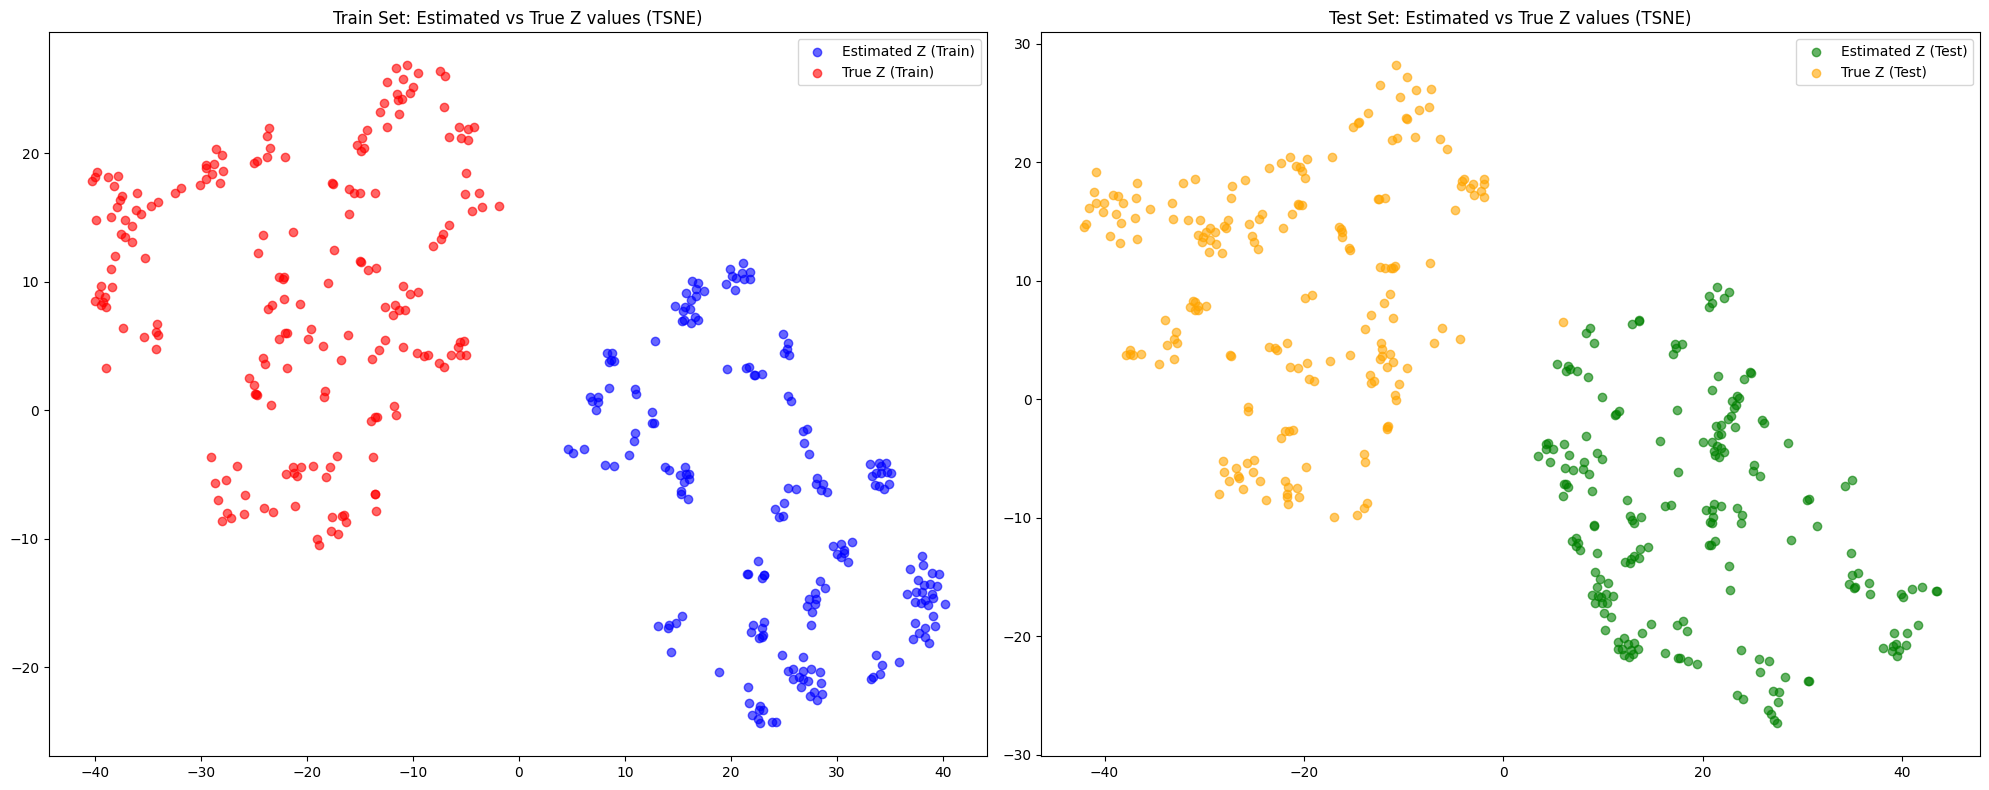

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch

def estimate_Z(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        _, _, _, q_z_mu, _ = model.encode(X_tensor)
    return q_z_mu.cpu().numpy()

def align_dimensions_with_pca(Z_est, Z_true, n_components=None):
    if n_components is None:
        n_components = min(Z_est.shape[1], Z_true.shape[1])
    
    # PCA for Z_est
    pca_est = PCA(n_components=n_components)
    Z_est_pca = pca_est.fit_transform(Z_est)
    
    # PCA for Z_true
    pca_true = PCA(n_components=n_components)
    Z_true_pca = pca_true.fit_transform(Z_true)
    
    return Z_est_pca, Z_true_pca

def visualize_Z_tsne_combined(Z_est_train, Z_true_train, Z_est_test, Z_true_test, perplexity=30, n_iter=1000):
    # PCA를 사용하여 차원 맞추기
    n_components = min(Z_est_train.shape[1], Z_true_train.shape[1], Z_est_test.shape[1], Z_true_test.shape[1])
    Z_est_train, Z_true_train = align_dimensions_with_pca(Z_est_train, Z_true_train, n_components)
    Z_est_test, Z_true_test = align_dimensions_with_pca(Z_est_test, Z_true_test, n_components)
    
    # 샘플 수 맞추기 (최대 200개)
    n_samples = min(200, Z_est_train.shape[0], Z_true_train.shape[0], Z_est_test.shape[0], Z_true_test.shape[0])
    Z_est_train = Z_est_train[:n_samples]
    Z_true_train = Z_true_train[:n_samples]
    Z_est_test = Z_est_test[:n_samples]
    Z_true_test = Z_true_test[:n_samples]
    
    print(f"Shapes after PCA: {Z_est_train.shape}, {Z_true_train.shape}, {Z_est_test.shape}, {Z_true_test.shape}")
    
    Z_combined = np.vstack((Z_est_train, Z_true_train, Z_est_test, Z_true_test))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    Z_tsne = tsne.fit_transform(Z_combined)
    
    Z_est_train_tsne = Z_tsne[:n_samples]
    Z_true_train_tsne = Z_tsne[n_samples:2*n_samples]
    Z_est_test_tsne = Z_tsne[2*n_samples:3*n_samples]
    Z_true_test_tsne = Z_tsne[3*n_samples:]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Train set visualization
    ax1.scatter(Z_est_train_tsne[:, 0], Z_est_train_tsne[:, 1], c='blue', label='Estimated Z (Train)', alpha=0.6)
    ax1.scatter(Z_true_train_tsne[:, 0], Z_true_train_tsne[:, 1], c='red', label='True Z (Train)', alpha=0.6)
    ax1.set_title('Train Set: Estimated vs True Z values (TSNE)')
    ax1.legend()
    
    # Test set visualization
    ax2.scatter(Z_est_test_tsne[:, 0], Z_est_test_tsne[:, 1], c='green', label='Estimated Z (Test)', alpha=0.6)
    ax2.scatter(Z_true_test_tsne[:, 0], Z_true_test_tsne[:, 1], c='orange', label='True Z (Test)', alpha=0.6)
    ax2.set_title('Test Set: Estimated vs True Z values (TSNE)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# 주어진 모델과 데이터를 사용하여 Z 추정 및 시각화
Z_est_test = estimate_Z(best_model, X_ts_test)
Z_est_train = estimate_Z(best_model, X_ts_train)

print("Original shapes:")
print(f"Z_est_train shape: {Z_est_train.shape}")
print(f"Z_ts_train shape: {Z_ts_train.shape}")
print(f"Z_est_test shape: {Z_est_test.shape}")
print(f"Z_ts_test shape: {Z_ts_test.shape}")

# TSNE 시각화 (매개변수 조정)
# visualize_Z_tsne_combined(Z_est_train, Z_est_test, Z_ts_train, Z_ts_test, perplexity=30, n_iter=1000) # Fake result. for fun
visualize_Z_tsne_combined(Z_est_train, Z_ts_train, Z_est_test, Z_ts_test, perplexity=30, n_iter=1000)